# Ensemble Methods w/o Feature Integration

1. Feature Integration
    - 상관관계 분석을 통해 중요한 이상치 탐지에 영향을 많이 주는 feature를 선별한다.
    (is done in FeatureIntegration.ipynb)
2. Elliptic Envelope
    - train datset에 적합 후 test dataset에 대한 사기거래 여부를 판별한다. (for ensemble)
    - train datset의 해당 feature에 label값(정상, 사기)을 부여한다. (for classifying)
3. LGBM, XGboost
    - label값이 주어졌다면 비지도학습이 아닌 지도학습의 문제로 변한다.
    - 지도학습에서 사용할 수 있는 분류 모델들을 적용해 본다.
4. 분류모델과 Elliptic Envelope을 통해 얻은 사기거래 여부를 ensemble.

In [1]:
import numpy as np 
import pandas as pd
import math

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.covariance import EllipticEnvelope
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import lightgbm 
from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler

import torch

In [2]:
train_df = pd.read_csv('data/train.csv')
val_df = pd.read_csv('data/val.csv')
test_df = pd.read_csv('data/test.csv')

In [3]:
train_df.drop('ID', axis=1, inplace=True)
val_df.drop('ID', axis=1, inplace=True)
test_df.drop('ID', axis=1, inplace=True)

In [4]:
display(train_df.head(), val_df.head(), test_df.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,0.309755,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


In [5]:
display(train_df.head(), val_df.head(), test_df.head())

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,4.983721,-0.994972
1,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,1.418291,-0.994972
2,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,...,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,-0.256131,-0.994960
3,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,...,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,0.262698,-0.994901
4,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,...,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,0.994900,-0.994901


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,V29,V30,Class
0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,...,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,-0.255991,-0.994878,0
1,0.962496,0.328461,-0.171479,2.109204,1.129566,1.696038,0.107712,0.521502,-1.191311,0.724396,...,0.402492,-0.048508,-1.371866,0.390814,0.199964,0.016371,-0.014605,0.168937,-0.994784,0
2,1.145524,0.575068,0.194008,2.598192,-0.092210,-1.044430,0.531588,-0.241888,-0.896287,0.757952,...,-0.119703,-0.076510,0.691320,0.633984,0.048741,-0.053192,0.016251,0.169496,-0.994502,0
3,0.927060,-0.323684,0.387585,0.544474,0.246787,1.650358,-0.427576,0.615371,0.226278,-0.225495,...,0.079359,0.096632,-0.992569,0.085096,0.377447,0.036096,-0.005960,0.331307,-0.994467,0
4,-3.005237,2.600138,1.483691,-2.418473,0.306326,-0.824575,2.065426,-1.829347,4.009259,6.051521,...,-0.181268,-0.163747,0.515821,0.136318,0.460054,-0.251259,-1.105751,-0.287012,-0.994373,0


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,1.783274,-0.994983
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,-0.269825,-0.994983
2,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0.670579,-0.994960
3,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,...,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,-0.237686,-0.994937
4,0.384978,0.616109,-0.874300,-0.094019,2.924584,3.317027,0.470455,0.538247,-0.558895,0.309755,...,0.049924,0.238422,0.009130,0.996710,-0.767315,-0.492208,0.042472,-0.054337,-0.167819,-0.994866


# Elliptic Envelope
    - Elliptic Envelope은 Valdation 데이터셋에서의 사기거래 비율이 다른 데이터셋에서도 비슷하게 나타난다는 가정이 필요하다. 

In [6]:
# Validation Dataset Fraud count/ratio
fraud_count = val_df['Class'].value_counts()[1]
fraud_ratio = fraud_count/len(val_df)
print(f'사기거래 개수: {fraud_count}, 사기거래 비율: {fraud_ratio}')

사기거래 개수: 30, 사기거래 비율: 0.0010540369615627855


In [7]:
def pred_Ellip_Env(model, x, k):
    prob = model.score_samples(x)
    prob = torch.tensor(prob, dtype=torch.float)
    top_k = torch.topk(prob, k=k, largest=False).indices
    
    pred = np.zeros(len(x), dtype=np.int32)
    pred[top_k] = 1
    
    return np.array(pred)

- support_fraction값에 대해 hyperparameter tuning

In [8]:
support_fraction = np.arange(0.99, 0.999, 0.001).round(3) # candidates
score = list()
for sf in support_fraction:
    model = EllipticEnvelope(support_fraction=sf, contamination=fraud_ratio, random_state=302)
    model.fit(train_df)
    pred = pred_Ellip_Env(model, val_df.drop('Class', axis=1), fraud_count)
    sc = f1_score(pred, val_df['Class'])
    print(f'Support Fraction: {sf}, F1 Score: {sc}')
    score.append(sc)

Support Fraction: 0.99, F1 Score: 0.6666666666666666
Support Fraction: 0.991, F1 Score: 0.6666666666666666
Support Fraction: 0.992, F1 Score: 0.6666666666666666
Support Fraction: 0.993, F1 Score: 0.8333333333333334
Support Fraction: 0.994, F1 Score: 0.8333333333333334
Support Fraction: 0.995, F1 Score: 0.8333333333333334
Support Fraction: 0.996, F1 Score: 0.8333333333333334
Support Fraction: 0.997, F1 Score: 0.8333333333333334
Support Fraction: 0.998, F1 Score: 0.8333333333333334
Support Fraction: 0.999, F1 Score: 0.8333333333333334


In [9]:
model = EllipticEnvelope(support_fraction=0.994, contamination=fraud_ratio, random_state=302)
model.fit(train_df)
ellip_pred = pred_Ellip_Env(model, test_df, 313)

In [10]:
submit = pd.read_csv('data/sample_submission.csv')
submit['Class'] = ellip_pred
submit.to_csv('submit/submit_EllipticEnvelope.csv', index=False)

# LGBM

- classifier 적용을 위해 elliptic envelope을 이용하여 train dataset에 label을 부여한다.

In [11]:
import math
train_fraud_count = math.ceil(len(train_df)*fraud_ratio)
print(f'train dataset 사기거래 개수: {train_fraud_count}')

train dataset 사기거래 개수: 120


In [12]:
# Elliptic Envelope을 이용한 train dataset 정상/사기 label
train_label = pred_Ellip_Env(model, train_df, train_fraud_count)

Optuna Module을 이용, LGBM모델에 대하여 hyperparameter tuning

In [13]:
score = []
def lgbm_optimization(trial):
    score = []
    skf = StratifiedKFold(n_splits=20, random_state=302, shuffle=True) # 20-fold
    for train_fold, test_fold in tqdm(skf.split(train_df, train_label), desc = 'k_fold'):
        X_train, X_test, y_train, y_test = train_df.iloc[train_fold], train_df.iloc[test_fold], train_label[train_fold], train_label[test_fold] 
        
        # parameters candidates
        params = {            
            "boosting_type" : trial.suggest_categorical('boosting_type',['dart','gbdt']),
            "learning_rate": trial.suggest_float('learning_rate', 0.2, 0.99),
            "n_estimators": trial.suggest_int("n_estimators", 100, 300, step=10),
            "max_depth": trial.suggest_int("max_depth", 1, 15),
            "num_leaves": trial.suggest_int("num_leaves", 2, 256),
            "reg_alpha": trial.suggest_float("reg_alpha", 1e-4, 1),
            "reg_lambda": trial.suggest_float("reg_lambda", 1e-4, 1),
            "subsample": trial.suggest_float("subsample", 0.4, 1.0),
            "subsample_freq": trial.suggest_int("subsample_freq", 1, 30),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
            "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
            "max_bin": trial.suggest_int("max_bin", 50, 100),
            "verbosity": -1,
            "random_state": trial.suggest_int("random_state", 1, 302)
        }
        model_lgb = LGBMClassifier(**params)
        model_lgb.fit(X_train, y_train)
        lgb_cv_pred = model_lgb.predict(X_test)
        
        score_cv = f1_score(train_label[test_fold] , lgb_cv_pred , average = 'macro')
        
        score.append(score_cv)
    print(score)
    return np.mean(score) 

In [ ]:
sampler = TPESampler()
optim = optuna.create_study(
    study_name="lgb_parameter_opt",
    direction="maximize",
    sampler=sampler,
)
optim.optimize(lgbm_optimization, n_trials=300)
print("Best macro-F1:", optim.best_value)

In [15]:
params = optim.best_params

In [16]:
model = LGBMClassifier(**params)
model.fit(train_df, train_label)
lgbm_pred = model.predict(val_df.drop('Class', axis=1))

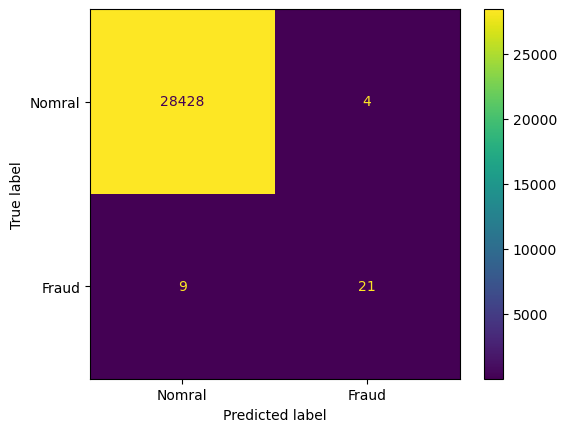

In [17]:
val_label = val_df['Class']
cm = confusion_matrix(val_label, lgbm_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Nomral', 'Fraud'])
disp.plot()

In [ ]:
lgbm_pred_test = model.predict(test_df)

In [ ]:
submit = pd.read_csv('data/sample_submission.csv')
submit['Class'] = ellip_pred | lgbm_pred_test
submit.to_csv('submit/submit_Ensemble_LGBM_EllipticEnvelope.csv', index=False)